**Interpret Sign Language with Deep Learning**
* Which sign represents which letter in the alphabet?  
* Looks like a task for [Deep Learning](https://www.kaggle.com/learn/deep-learning)!

American Sign Language (ASL) is a natural language that serves as the predominant sign language of Deaf communities in the United States and most of Anglophone Canada.  ASL possesses a set of 26 signs known as the American manual alphabet, which can be used to spell out words from the English language.  Source: https://en.wikipedia.org/wiki/American_Sign_Language

In this kernel I demonstrate that deep learning can be used to interpret these signs. 

*Step 1: Import Modules*

In [12]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, BatchNormalization, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, backend as K
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight 
from sklearn.utils.class_weight import compute_class_weight
import skimage
import os
from tensorflow.keras import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
from tqdm import tqdm
import random


*Step 2: Load Data*

In [13]:
# print(os.listdir("../input"))
# print(os.listdir("../input/asl-alphabet"))
# print(os.listdir("../input/asl-alphabet/asl_alphabet_train"))
# print(os.listdir("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"))
# print(os.listdir("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A"))

In [14]:
imageSize=75
#train_dir = "D:\ASL_Alphabet_Dataset\\asl_alphabet_train_transformed\\"
train_dir =  "D:\ASL_Alphabet_Dataset\\asl_alphabet_train_transformed\\"
test_dir =  "D:\ASL_Alphabet_Dataset\\asl_alphabet_test_transformed\\"
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['space']:
                label = 26
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir) 
#X_test, y_test= get_data(test_dir) # Too few images

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2) 

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 27)
y_testHot = to_categorical(y_test, num_classes = 27)
map_characters = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y',
    25: 'Z',
    26: 'space'
}


  4%|▍         | 186/4204 [00:01<00:30, 132.73it/s]


KeyboardInterrupt: 

In [4]:
# Shuffle data to permit further subsampling
from sklearn.utils import shuffle
X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_train = X_train[:30000]
X_test = X_test[:30000]
y_trainHot = y_trainHot[:30000]
y_testHot = y_testHot[:30000]

*Step 3: Vizualize Data*

The min/max pixel values are already scaled between 0 and 1

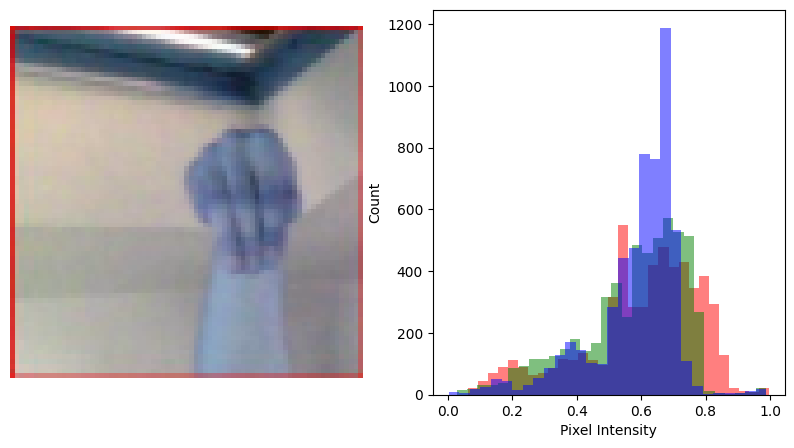

In [5]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

3 images from category "A"

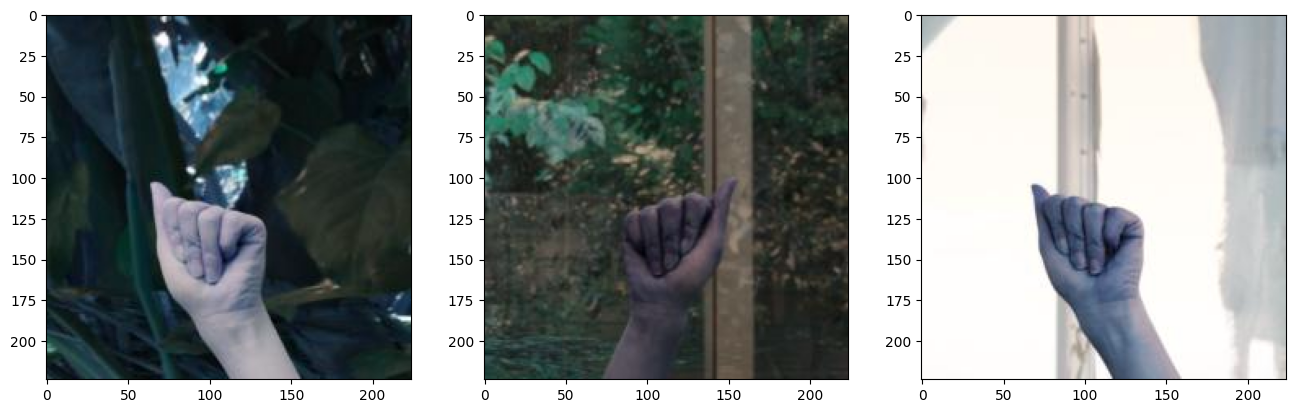

In [6]:
multipleImages = glob("D:\ASL_Alphabet_Dataset\\asl_alphabet_test_transformed\\A/**")
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]))
    #;
plotThreeImages(multipleImages)

3 images from category "B"

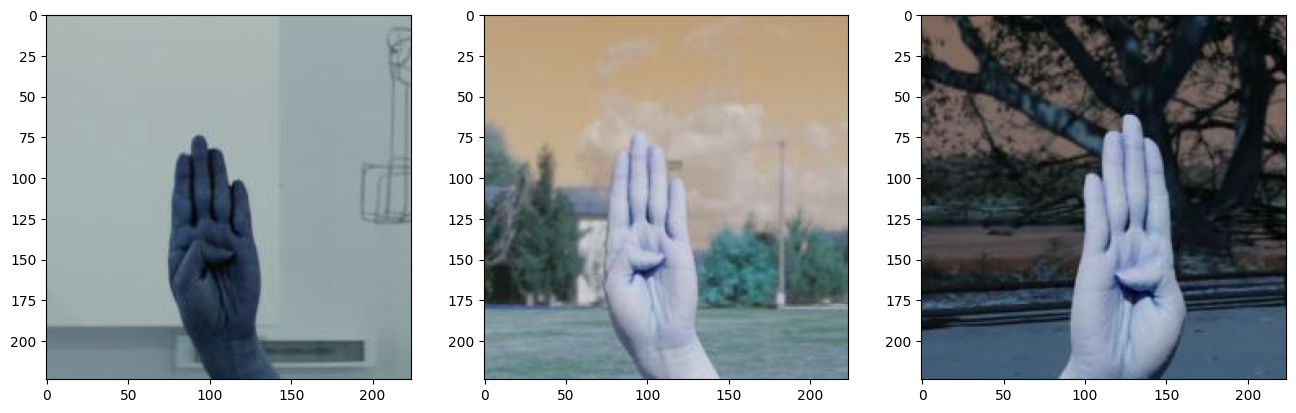

In [7]:
multipleImages = glob('D:\ASL_Alphabet_Dataset\\asl_alphabet_test_transformed\\B/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])) 
plotThreeImages(multipleImages)

20 images from category "A"

A


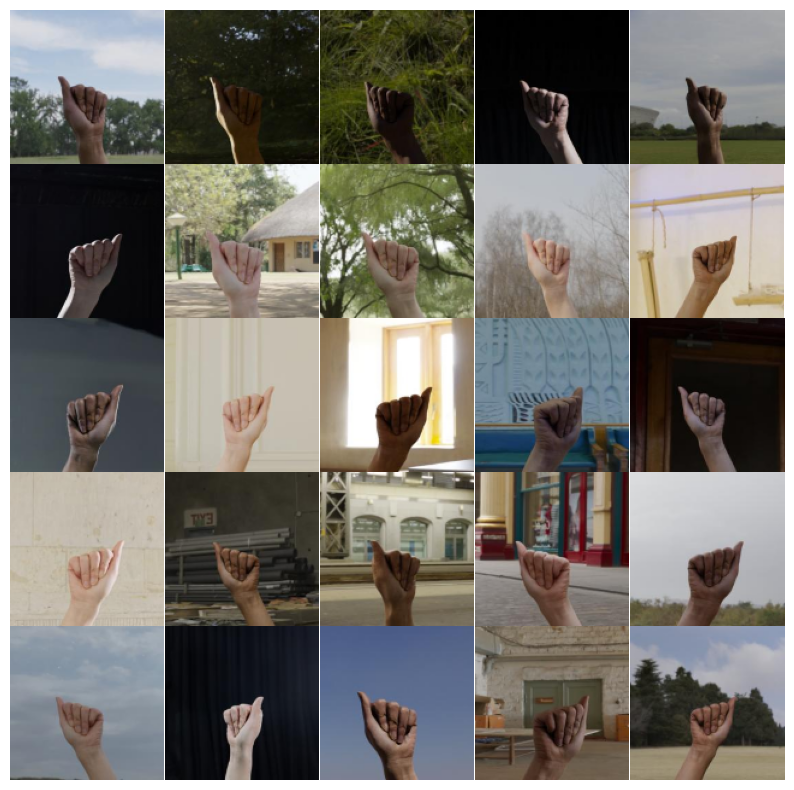

In [8]:
print("A")
multipleImages = glob('D:\ASL_Alphabet_Dataset\\asl_alphabet_test_transformed\\A/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

20 images from category "B"

B


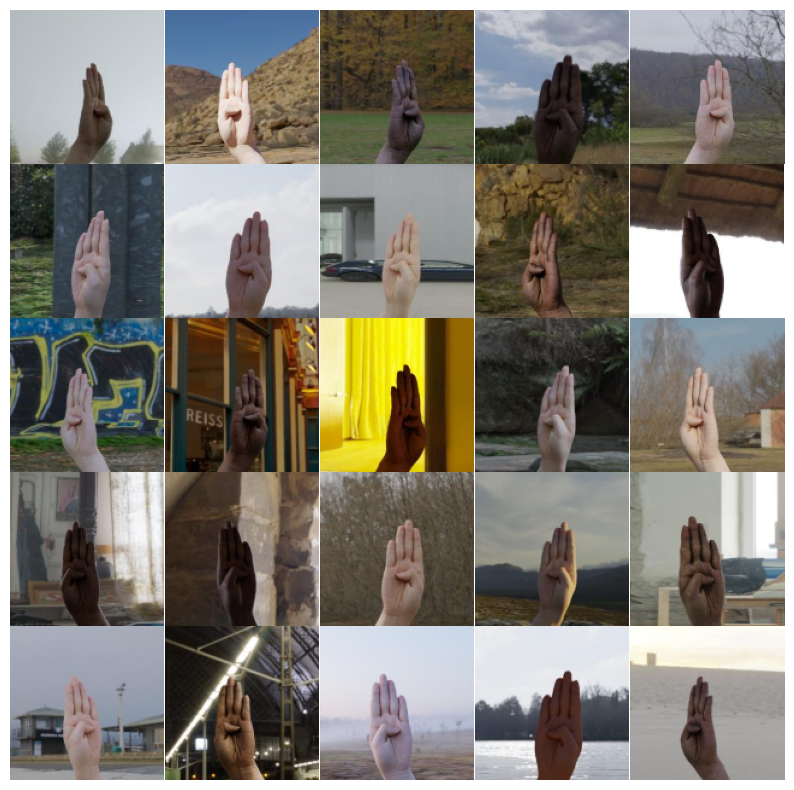

In [9]:
print("B")
multipleImages = glob('D:\ASL_Alphabet_Dataset\\asl_alphabet_test_transformed\\B/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

*Step 4: Define Helper Functions*

In [10]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

*Step 5: Evaluate Classification Models*

Transfer learning w/ VGG16 Convolutional Network

In [17]:
from sklearn.metrics import classification_report

optimizer = Adam(learning_rate=0.005)
weight_path1 = "D:/ASL_Alphabet_Dataset/Sign_language/SignLanguageToText/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Compute class weights
class_weight1 = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight1 = dict(enumerate(class_weight1))  # Convert to dictionary format

# Initialize the VGG16 model without weights, then load the custom weights
pretrained_model_1 = VGG16(weights=None, include_top=False, input_shape=(imageSize, imageSize, 3))
pretrained_model_1.load_weights(weight_path1)

# Define the function to build and train the network
def pretrainedNetwork(xtrain, ytrain, xtest, ytest, pretrained_model, class_weight, num_classes, num_epochs, optimizer, labels):
    base_model = pretrained_model
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Define callbacks: save model after each epoch and early stopping
    checkpoint_callback = ModelCheckpoint(
        filepath='asl_model_epoch.keras',  # Save model for each epoch with the epoch number in the filename
        save_freq='epoch',
        save_weights_only=False,
        verbose=1
    )
    early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

    callbacks_list = [checkpoint_callback, early_stopping_callback]

    # Model summary
    model.summary()

    # Fit the model
    history = model.fit(xtrain, ytrain, epochs=num_epochs, class_weight=class_weight,
                        validation_data=(xtest, ytest), verbose=1, callbacks=callbacks_list)

    # Evaluate and print accuracy
    score = model.evaluate(xtest, ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')

    # Predictions and reporting
    y_pred = model.predict(xtest)
    print(classification_report(np.argmax(ytest, axis=1), np.argmax(y_pred, axis=1), target_names=list(labels.values())))

    return model

# Execute the function with provided arguments
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot, pretrained_model_1, class_weight1, 27, 20, optimizer, map_characters)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 75, 75, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │        55,323 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,770,011 (56.34 MB)

 Trainable params: 55,323 (216.11 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5885 - loss: 1.5468
Epoch 1: saving model to asl_model_epoch.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 268s 285ms/step - accuracy: 0.5886 - loss: 1.5462 - val_accuracy: 0.8539 - val_loss: 0.5464
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8760 - loss: 0.4611
Epoch 2: saving model to asl_model_epoch.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 269s 287ms/step - accuracy: 0.8760 - loss: 0.4610 - val_accuracy: 0.8913 - val_loss: 0.3969
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9230 - loss: 0.2932
Epoch 3: saving model to asl_model_epoch.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 270s 288ms/step - accuracy: 0.9230 - loss: 0.2932 - val_accuracy: 0.9205 - val_loss: 0.3019
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9407 - loss: 0.2218
Epoch 4: saving model to asl_model_epoch.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 278s 297ms/step - accuracy: 0.9406 - loss: 0.2218 - val_accuracy: 0.

KeyboardInterrupt: 

Great, we were able to interpret the signs with an accuracy rate of approximately 92%.  That is much better than random chance given that there were 26 different signs!

In [12]:
# To Do: (1) try using more than 30000 of the 87000 images; (2) try using larger images; (3) try using different network architectures 